# **1. Importing packages and loading data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Misc_Face_Mask_Detection/data.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Misc_Face_Mask_Detection/data.zip
   creating: data/
   creating: data/without_mask/
  inflating: data/without_mask/0.jpg  
  inflating: data/without_mask/0_0_aidai_0014.jpg  
  inflating: data/without_mask/0_0_aidai_0029.jpg  
  inflating: data/without_mask/0_0_aidai_0043.jpg  
  inflating: data/without_mask/0_0_aidai_0074.jpg  
  inflating: data/without_mask/0_0_aidai_0084.jpg  
  inflating: data/without_mask/0_0_aidai_0136.jpg  
  inflating: data/without_mask/0_0_anhu_0004.jpg  
  inflating: data/without_mask/0_0_anhu_0020.jpg  
  inflating: data/without_mask/0_0_anhu_0025.jpg  
  inflating: data/without_mask/0_0_anhu_0027.jpg  
  inflating: data/without_mask/0_0_anhu_0056.jpg  
  inflating: data/without_mask/0_0_anhu_0057.jpg  
  inflating: data/without_mask/0_0_anhu_0062.jpg  
  inflating: data/without_mask/0_0_anhu_0063.jpg  
  inflating: data/without_mask/0_0_anhu_0098.jpg  
  inflating: data/without_mask/0_0_anhu_0103.jpg  
  inf

In [3]:
# import the necessary packages
#!pip install tensorflow==2.4.1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from cv2 import cv2
import warnings
import os

warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

In [4]:
import tensorflow as tf
print(tf.__version__)
# Tensorflow version used 2.4.1

2.4.1


- load_img : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img

- img_to_array : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/img_to_array

In [5]:
def data_extractor(DIRECTORY,CATEGORIES):
  data = []
  labels = []
  print("[INFO] loading images...")
  for category in CATEGORIES:
      path = os.path.join(DIRECTORY, category)
      for img in os.listdir(path):
        img_path = os.path.join(path, img)
        # Images are loaded in PIL format
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)
  print(f'Total Images : {len(data)}')
  return data,labels

In [6]:
DIRECTORY = '/content/data'
CATEGORIES = ["with_mask", "without_mask"]

data, labels = data_extractor(DIRECTORY,CATEGORIES)

[INFO] loading images...
Total Images : 3833


# **2. Visualizing sample images and class distribution**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


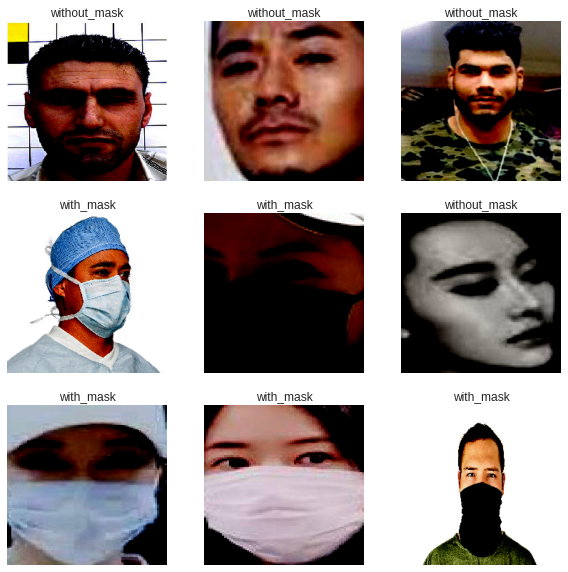

In [7]:
# Visualizing 9 random images
plt.figure(figsize=(10,10))
for i in range(1,10):
  plt.subplot(3,3,i)
  random_num = np.random.randint(0,len(data))
  plt.imshow(data[random_num][:,:,:])
  plt.title(labels[random_num])
  plt.grid(False)
  plt.axis('off')

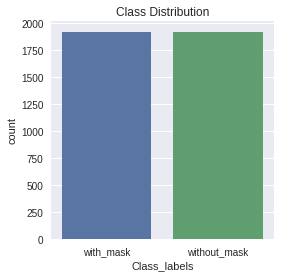

In [8]:
# Checking distribution of classes in train set
df = pd.DataFrame(labels,columns=["Class_labels"])
plt.figure(figsize=(4,4))
plt.title("Class Distribution")
sns.countplot(x='Class_labels',data=df)
plt.show()

# **3. Data preparation**

In [9]:
seed = 100
np.random.seed(seed)

## **a) Encoding output labels**

In [10]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

## **b) Perfroming Train-Test Split**

In [11]:
from sklearn.model_selection import train_test_split

valRatio = 0.2
data = np.array(data, dtype="float32")
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=valRatio, random_state=seed,stratify=labels)
print("Shape of train set",X_train.shape)
print("Shape of validation set",X_test.shape)

Shape of train set (3066, 224, 224, 3)
Shape of validation set (767, 224, 224, 3)


## **c) Data Augmentation**

In [12]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# **4. Model building and training**

In [13]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

path = f"/content/drive/MyDrive/Colab Notebooks/Misc_Face_Mask_Detection/mobileNet_model.h5"
  # Instantiating Callbacks
checkpoint = ModelCheckpoint(path,
                                monitor="val_loss",
                                mode="min",
                                save_best_only = True,
                                verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss', 
                              min_delta = 0, 
                              patience = 4,
                              verbose = 1,
                              restore_best_weights = True)
callbacks = [earlystop, checkpoint]

# train the head of the network
print("[INFO] training head...")
model.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS,
  callbacks=callbacks)

9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/20
94/95 [============================>.] - ETA: 0s - loss: 0.5841 - accuracy: 0.7173

# **5. Model Evaluation**

In [ ]:
def plot_validation_curves(result):
  result = pd.DataFrame(result)
  fig, axs = plt.subplots(1,2)
  result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
  axs[0].set_title('Train vs validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  result[['accuracy','val_accuracy']].plot(figsize=(10, 3),ax=axs[1])
  axs[1].set_title('Train vs validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

plot_validation_curves(model.history.history)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

def plot_summary(pred_prob):
  '''
  Plots confustion matrix and classification report.
  '''
  # Selecting class based on higher probabilities
  y_pred_classes = np.argmax(pred_prob,axis=1)
  # Reverting one-hot encoding on true validation output labels
  y_test_classes = np.argmax(y_test,axis=1)
  print("***************** CLASSIFICATION REPORT *****************")
  print(classification_report(y_test_classes,y_pred_classes),"\n\n")
  print("******************* CONFUSION MATRIX *******************")
  plt.figure(figsize=(8,8))
  sns.heatmap(confusion_matrix(y_test_classes,y_pred_classes),linewidths=.5,cmap="YlGnBu",annot=True,cbar=False,fmt='d')
  plt.show()

In [ ]:
pred_prob = model.predict(X_test)
plot_summary(pred_prob)